In [9]:
# Data handling
import numpy as np
import pandas as pd

# Machine learning: preprocessing and feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold, cross_validate

# Machine learning: models
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Machine learning: model selection and evaluation
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, precision_recall_curve,
                             roc_curve, RocCurveDisplay, average_precision_score)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Imbalanced data handling
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler


### Preprocessing 

In [2]:
# Load dataset
df = pd.read_csv("NHANES_data_stroke_train.csv")

# Basic Data Cleaning
df = df.replace({'NA': pd.NA})  # Convert 'NA' strings to actual NA values and map {2, 1} to {0, 1} for binary features
df['stroke'] = df['stroke'].map({2: 0, 1: 1})

# Convert 'Edu' to a categorical feature
df['Edu'] = df['Edu'].astype('category')

# Generate cross terms as specified
df['age_systolic'] = df['Age'] * df['Systolic']
df['age_tchol'] = df['Age'] * df['TCHOL']
df['age_hdl'] = df['Age'] * df['HDL']
df['age_smoker'] = df['Age'] * df['CurrentSmoker']

# Categorical and numerical features (update as needed)
categorical_features = ['Sex', 'Race', 'CurrentSmoker', 'isActive', 'isInsured', 'Diabetes', 'Edu']
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features += ['age_systolic', 'age_tchol', 'age_hdl', 'age_smoker']  # Add cross terms

# Remove the target variable 'stroke' if included
numerical_features = [col for col in numerical_features if col not in ['stroke']]

# Define preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputing missing values with the mean
    ('scaler', StandardScaler()),  # Standardizing features
    ('var_thresh', VarianceThreshold(0.01))  # Removing low-variance features
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputing missing values with the mode
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encoding categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Split dataset
X = df.drop('stroke', axis=1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply transformations - Now integrated directly into model pipelines, not separately
# X_train_transformed = preprocessor.fit_transform(X_train)
# X_test_transformed = preprocessor.transform(X_test)


In [10]:
# Load dataset
df = pd.read_csv("NHANES_data_stroke_train.csv")

# Perform imputation for missing values (example with mean imputation for simplicity)
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Convert 'NA' strings to actual NA values and map {2, 1} to {0, 1} for binary features
df_imputed = df_imputed.replace({'NA': pd.NA, '2': 0, '1': 1})

# Ensure all categorical features are of type 'category' (important for OneHotEncoder in preprocessor)
categorical_features = ['Sex', 'Race', 'CurrentSmoker', 'isActive', 'isInsured', 'Diabetes']
df_imputed[categorical_features] = df_imputed[categorical_features].astype('category')

# Split dataset
X = df_imputed.drop('stroke', axis=1)
y = df_imputed['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop 'SEQN' column if it exists
X_train = X_train.drop(columns=['SEQN'], errors='ignore')
X_test = X_test.drop(columns=['SEQN'], errors='ignore')

# Initialize the classifier
classifier = RandomForestClassifier(random_state=42)

# Feature selector with cross-validation
selector = RFECV(estimator=classifier, step=3, cv=StratifiedKFold(3),
                 scoring=make_scorer(accuracy_score))

# Fit RFECV
selector = selector.fit(X_train, y_train)

# Report the optimal number of features and which are selected
print(f"Optimal number of features: {selector.n_features_}")
print(f"Best features: {X_train.columns[selector.support_]}")

# Select the features that were determined to be most important
selected_features = X_train.columns[selector.support_]

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the selected features of the training and testing set
X_train_scaled = scaler.fit_transform(X_train[selected_features])
X_test_scaled = scaler.transform(X_test[selected_features])

# Update the datasets
X_train = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)


Optimal number of features: 15
Best features: Index(['Income', 'Age', 'Race', 'Edu', 'Diastolic', 'Systolic', 'Pulse', 'BMI',
       'HDL', 'Trig', 'LDL', 'TCHOL', 'kidneys_eGFR', 'Diabetes',
       'CurrentSmoker'],
      dtype='object')


In [11]:
# Define a pipeline without the preprocessor if it's already done
dt_pipeline = ImbPipeline(steps=[
    # ('preprocessor', preprocessor), # Omitted because preprocessing is done manually outside
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=2, random_state=42))
])

# Train the Decision Tree Classifier with the best hyperparameters using already processed data
dt_pipeline.fit(X_train, y_train)

# Predict with the trained Decision Tree
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))



Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

         1.0       0.10      0.28      0.15        36
         2.0       0.96      0.88      0.92       783

    accuracy                           0.86       819
   macro avg       0.53      0.58      0.53       819
weighted avg       0.93      0.86      0.89       819



### Decision Tree

In [3]:
dt_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=2, random_state=42))
])

# Train the Decision Tree Classifier with the best hyperparameters
dt_pipeline.fit(X_train, y_train)

# Predict with the trained Decision Tree
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluation (optional, as needed)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Accuracy: 0.927960927960928
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       783
           1       0.17      0.17      0.17        36

    accuracy                           0.93       819
   macro avg       0.57      0.56      0.57       819
weighted avg       0.93      0.93      0.93       819



### SVM

In [4]:
svm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    # Update the classifier step with the best hyperparameters for SVC
    ('classifier', SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42))
])

# Train the SVM Classifier with the best hyperparameters
svm_pipeline.fit(X_train, y_train)

# Predict with the trained SVM
y_pred_svm = svm_pipeline.predict(X_test)

# Evaluation (optional, as needed)
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Accuracy: 0.9218559218559218
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       783
           1       0.17      0.19      0.18        36

    accuracy                           0.92       819
   macro avg       0.56      0.57      0.57       819
weighted avg       0.93      0.92      0.92       819



### Random Forest

In [5]:
rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42))
])

# Train the RandomForest Classifier with the best hyperparameters
rf_pipeline.fit(X_train, y_train)

# Predict with the trained RandomForest
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluation
print("Classification Report for RandomForest:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_rf))


Classification Report for RandomForest:
Accuracy: 0.9218559218559218
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       783
           1       0.17      0.03      0.05        36

    accuracy                           0.95       819
   macro avg       0.56      0.51      0.51       819
weighted avg       0.92      0.95      0.93       819



### Gradient Boosting

In [6]:
gb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(
        n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42     
    ))
])

# Train the Gradient Boosting Classifier with the best hyperparameters
gb_pipeline.fit(X_train, y_train)

# Predict with the trained Gradient Boosting
y_pred_gb = gb_pipeline.predict(X_test)

# Evaluation
print("Classification Report for Gradient Boosting:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_gb))


Classification Report for Gradient Boosting:
Accuracy: 0.9218559218559218
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       783
           1       0.19      0.17      0.18        36

    accuracy                           0.93       819
   macro avg       0.57      0.57      0.57       819
weighted avg       0.93      0.93      0.93       819



## Model Evaluation

Decision Tree Performance:
Accuracy: 0.9280
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       783
           1       0.17      0.17      0.17        36

    accuracy                           0.93       819
   macro avg       0.57      0.56      0.57       819
weighted avg       0.93      0.93      0.93       819




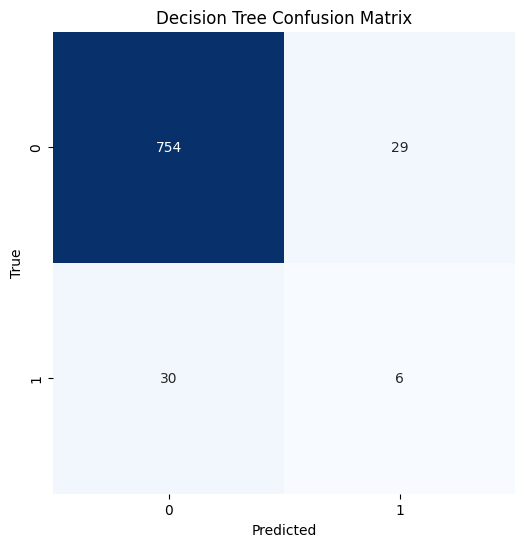

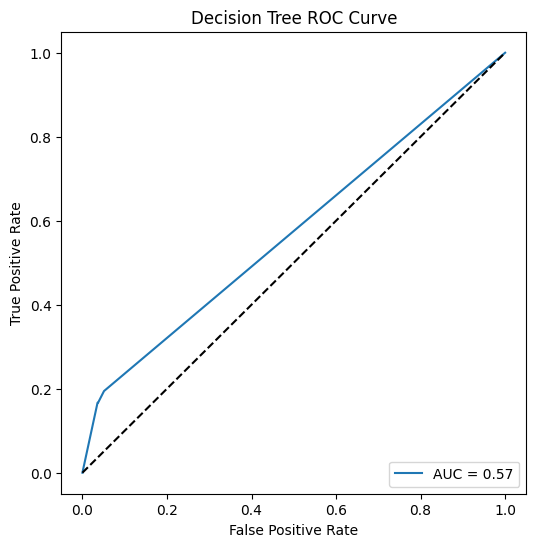

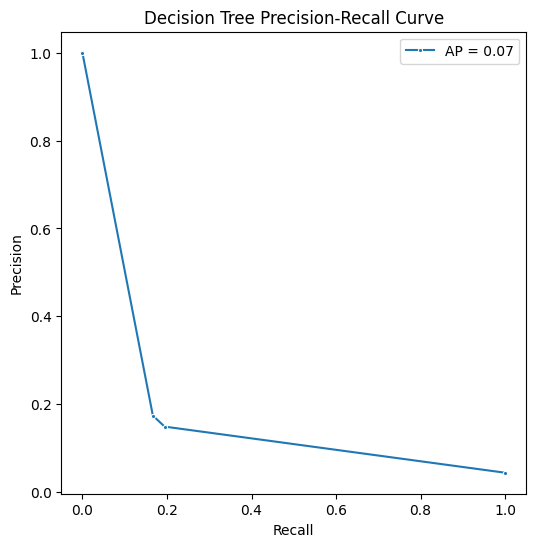

SVM Performance:
Accuracy: 0.9219
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       783
           1       0.17      0.19      0.18        36

    accuracy                           0.92       819
   macro avg       0.56      0.57      0.57       819
weighted avg       0.93      0.92      0.92       819




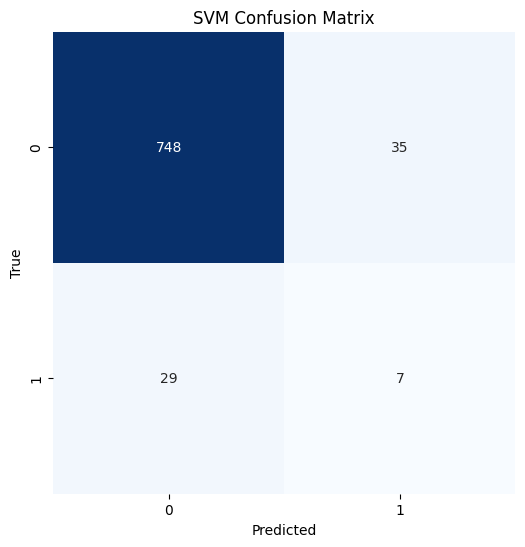

Random Forest Performance:
Accuracy: 0.9512
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       783
           1       0.17      0.03      0.05        36

    accuracy                           0.95       819
   macro avg       0.56      0.51      0.51       819
weighted avg       0.92      0.95      0.93       819




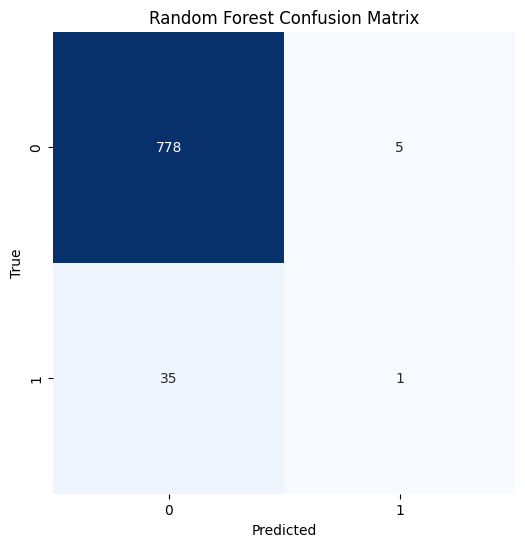

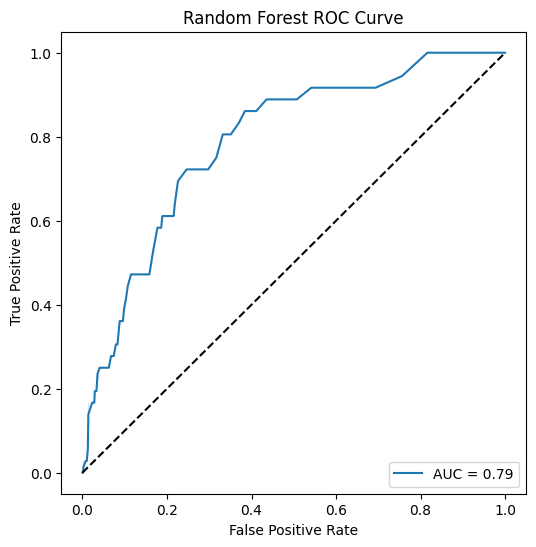

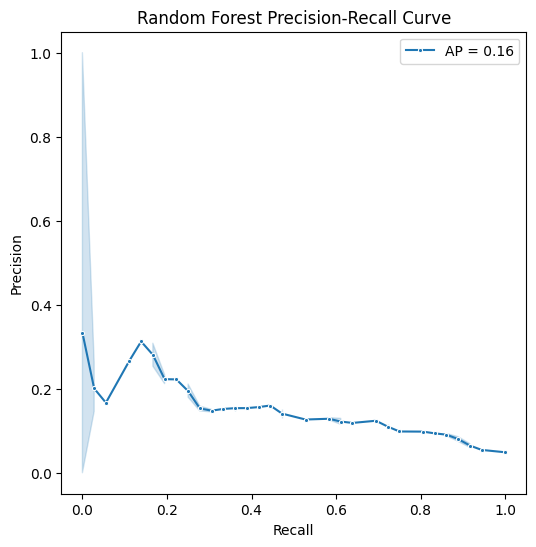

Gradient Boosting Performance:
Accuracy: 0.9316
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       783
           1       0.19      0.17      0.18        36

    accuracy                           0.93       819
   macro avg       0.57      0.57      0.57       819
weighted avg       0.93      0.93      0.93       819




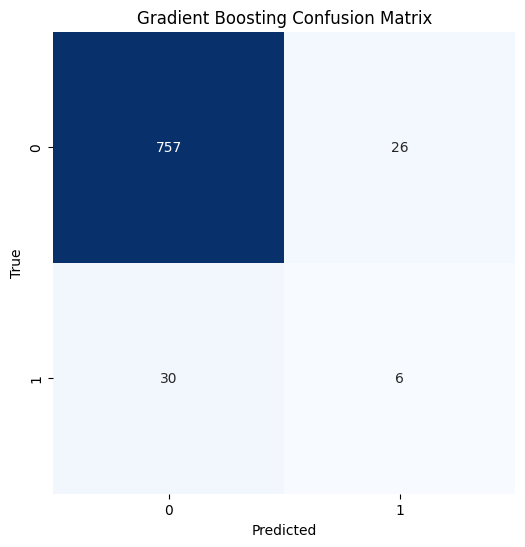

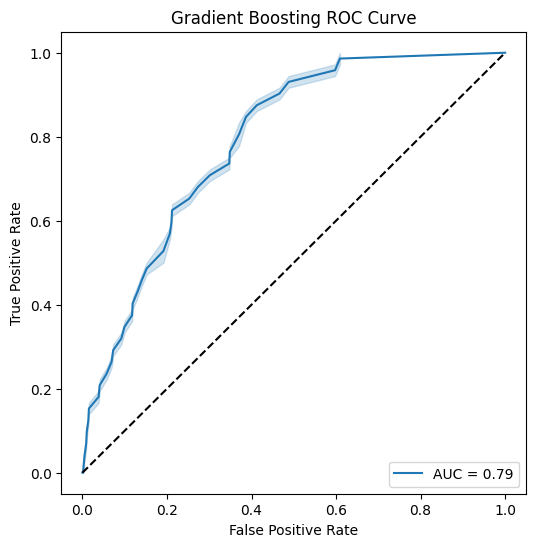

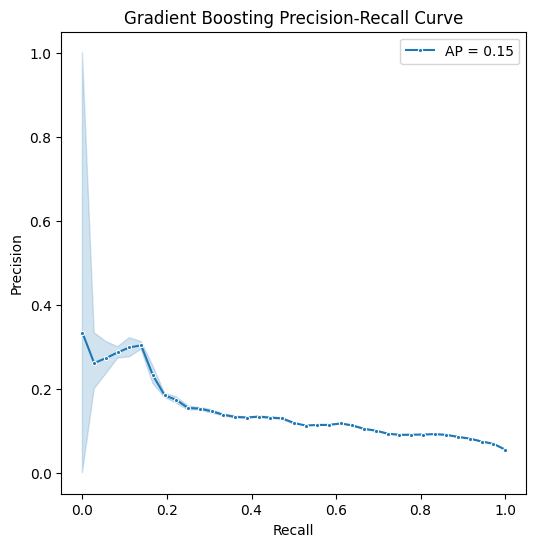

In [7]:
def evaluate_model(model, model_name, X_test, y_test, feature_names=None):
    """
    Evaluates a machine learning model's performance and displays relevant metrics and plots.

    Parameters:
    - model: The trained machine learning model.
    - model_name: A string, the name of the model.
    - X_test: Test features.
    - y_test: True labels for the test data.
    - feature_names: List of feature names for plotting feature importances. Optional.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Basic Evaluation Metrics
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    # ROC Curve and AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 6))
        sns.lineplot(x=fpr, y=tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
        plt.title(f'{model_name} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()
    
        # Precision-Recall Curve and Average Precision
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        ap_score = average_precision_score(y_test, y_prob)
        plt.figure(figsize=(6, 6))
        sns.lineplot(x=recall, y=precision, marker='.', label=f'AP = {ap_score:.2f}')
        plt.title(f'{model_name} Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()
    
    # Feature Importances (for models that support this)
    if hasattr(model, "feature_importances_") and feature_names is not None:
        importances = model.named_steps['classifier'].feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=np.array(feature_names)[indices], y=importances[indices], palette='Blues_d')
        plt.xticks(rotation=90)
        plt.title(f'{model_name} Feature Importances')
        plt.ylabel('Importance')
        plt.xlabel('Feature')
        plt.show()



evaluate_model(dt_pipeline, "Decision Tree", X_test, y_test, feature_names=X_train.columns.tolist())
evaluate_model(svm_pipeline, "SVM", X_test, y_test)
evaluate_model(rf_pipeline, "Random Forest", X_test, y_test, feature_names=X_train.columns.tolist())
evaluate_model(gb_pipeline, "Gradient Boosting", X_test, y_test, feature_names=X_train.columns.tolist())



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.feature_selection import RFECV

print(X_train.head())

#X_train = X_train.drop(columns=['SEQN'])
#X_test = X_test.drop(columns=['SEQN'])

# Initialize the classifier
classifier = RandomForestClassifier()

# Feature selector with cross-validation
selector = RFECV(estimator=classifier, step=3, cv=StratifiedKFold(3),
                 scoring=make_scorer(accuracy_score))

# Fit RFECV
selector = selector.fit(X_train, y_train)

print(f"Optimal number of features : {selector.n_features_}")
print(f"Best features : {selector.support_}")

selected_features = X_train.columns[selector.support_]

# Scale the selected features of the training and testing set
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[selected_features])
X_test_scaled = scaler.transform(X_test[selected_features])

X_train = X_train_scaled
X_test = X_test_scaled

## Bad Feature Selection Stuff

In [ ]:
def get_transformed_feature_names(column_transformer):
    """
    Generates a list of names for the output features based on the transformers applied.
    """
    feature_names = []

    # Loop through each transformer in the ColumnTransformer
    for transformer in column_transformer.transformers_:
        transformer_name, transformer_obj, columns = transformer

        # Handle case for 'remainder' transformer
        if transformer_name == "remainder":
            continue

        # For transformers with a 'get_feature_names_out' method (e.g., OneHotEncoder)
        if hasattr(transformer_obj, 'get_feature_names_out'):
            if transformer_obj.__class__.__name__ == 'Pipeline':
                # If the transformer is a pipeline, apply to the last step
                transformer_last_step = transformer_obj.steps[-1][1]
                if hasattr(transformer_last_step, 'get_feature_names_out'):
                    names = transformer_last_step.get_feature_names_out(columns)
                else:
                    names = columns
            else:
                names = transformer_obj.get_feature_names_out(columns)
            feature_names.extend(names)
        else:
            # Fallback to column names if no method available
            feature_names.extend(columns)

    return feature_names

def evaluate_cross_validated_model(model, X, y, model_name, cv_folds=5):
    scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1_score': 'f1', 'roc_auc': 'roc_auc'}
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_estimator=True, n_jobs=-1)

    print(f"{model_name} - Cross-Validation Metrics:")
    for metric in scoring.keys():
        print(f"{metric}: {np.mean(cv_results['test_' + metric]):.4f}")

    if hasattr(model, 'named_steps') and 'classifier' in model.named_steps and hasattr(model.named_steps['classifier'], 'feature_importances_'):
        # Extract feature names correctly adjusted for the transformed feature space
        transformed_feature_names = get_transformed_feature_names(model.named_steps['preprocessor'])

        # Aggregate and plot feature importances, now correctly matching the transformed features
        feature_importances = np.mean([est.named_steps['classifier'].feature_importances_ for est in cv_results['estimator']], axis=0)
        
        indices = np.argsort(feature_importances)[::-1]
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=np.array(transformed_feature_names)[indices][:20], y=feature_importances[indices][:20], palette='Blues_d')  # Top 20 features
        plt.xticks(rotation=90)
        plt.title(f'{model_name} - Feature Importances')
        plt.ylabel('Importance')
        plt.xlabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature importances not available for {model_name}.")

evaluate_cross_validated_model(dt_pipeline, X_train, y_train, "Decision Tree")
evaluate_cross_validated_model(svm_pipeline, X_train, y_train, "SVM")
evaluate_cross_validated_model(rf_pipeline, X_train, y_train, "Random Forest")
evaluate_cross_validated_model(gb_pipeline, X_train, y_train, "Gradient Boosting")
